
# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads 2 npz files for your use: labels.npz and images.npz. For those not using colab you can download manually here:

https://drive.google.com/open?id=1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu

https://drive.google.com/open?id=1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW2')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
    '1Gth_AVG5t-4ZhH_whOaXwe0PBXNhIIK0': 'labels.npz',
    '1jIKQLhTHZUE6m2mE5lRKMSqN7ZGK2Gyu': 'images.npz'
           }

# download all files into the vm
for fid, fn in id_to_fn.items():
    download_file(fn, fid)

Mounted at /content/gdrive


In [0]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.ticker as plticker
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tnrange, tqdm_notebook
from sklearn import metrics
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from inspect import signature
from sklearn.model_selection import train_test_split
import torch
import torchvision

from pdb import set_trace as debug

In [0]:
## Helper Functions
def unzip_data(my_data):
  list_files = my_data.files
  if len(list_files):
    return my_data[list_files[0]]
  else:
    print('data is packed in multiple lists, change your logic')
    
def format_labels(ini_labels, step = 16.0, n_classes = 3, 
                  im_w = 128.0, im_h = 128.0):
  
  label_array = np.zeros([len(ini_labels), 8, 8, 8])
  
  for k, lab1 in enumerate(ini_labels):

    center_X, center_Y = (lab1[:,3] + lab1[:,1]) / 2.0, (lab1[:,4] + lab1[:,2]) / 2.0
    box_w, box_h = (lab1[:,3] - lab1[:,1])/im_w, (lab1[:,4] - lab1[:,2])/im_h
    rel_pos_w, rel_pos_h = np.floor(center_X / step).astype(int), np.floor(center_Y / step).astype(int)
    
    anchor_x, anchor_y = (center_X - 16*(rel_pos_w))/16.0, (center_Y - 16*(rel_pos_h))/16.0 
    
    
    label_array[k,rel_pos_w, rel_pos_h, 0] = 1.0
    label_array[k,rel_pos_w, rel_pos_h, 1:5] = np.concatenate(
                                                (anchor_x.reshape(-1, 1),
                                                 anchor_y.reshape(-1, 1), 
                                                 box_w.reshape(-1, 1), 
                                                 box_h.reshape(-1, 1)), axis = 1)
    
    label_vec = lab1[:, 0].astype(int)
    one_hot = np.eye(n_classes)[label_vec]
    
    label_array[k,rel_pos_w, rel_pos_h, 5:] = one_hot
    
  
  return label_array  
     

  
def test(net, device,optimizer, criterion, test_loader):
  net.eval()
  with torch.no_grad():
      corr = 0
      total = 0
      vali_loss = 0
      for i, (images_te, labels_te) in enumerate(test_loader):
          images_te = images_te.to(device)
          labels_te = labels_te.to(device)
          outputs_te = net(images_te)
          val_loss = criterion(outputs_te, labels_te)
          vali_loss += val_loss.item()

          valid_loss = vali_loss / len(test_loader)

          return valid_loss

  
def yolo_loss(X, Y, lambda_coord = 5, lambda_noobj = 0.5):
  X = X.double()
  Y = Y.double()
  
  label_1 = Y[Y[:, :, :, 0] == 1][:, 1:]
  X_1 = X[Y[:, :, :, 0] == 1][:, 1:]
  
  wh_sqrt_label = torch.sqrt(label_1[:, [2, 3]].clone())
  wh_sqrt_x = torch.sqrt(X_1[:, [2, 3]].clone())
  
  
  loss_a = (label_1[:, [0, 1]] - X_1[:, [0, 1]]).pow(2)
  loss_b = (wh_sqrt_label - wh_sqrt_x).pow(2)
  loss_c = (label_1[:, 5:] - X_1[:, 5:]).pow(2)
  
  loss_lambda1 = torch.sum(lambda_coord*(loss_a + loss_b)) + torch.sum(loss_c)
  
  label_10 = Y[:, :, :, 0]
  X_10 = X[:, :, :, 0]
  
  loss_d = (X_10 - label_10).double().pow(2)
  
  loss_lambda2 = torch.sum((lambda_noobj*loss_d[Y[:, :, :, 0] != 1])) + torch.sum(loss_d[Y[:, :, :, 0] == 1])
  
  return (loss_lambda1 + loss_lambda2) / len(X)
  

  
def yolo_loss(X, Y, lambda_coord = 5, lambda_noobj = 0.5):
  X = X.double()
  Y = Y.double()
  
  label_1 = Y[Y[:, :, :, 0] == 1][:, 1:]
  X_1 = X[Y[:, :, :, 0] == 1][:, 1:]
  
  wh_sqrt_label = torch.sqrt(label_1[:, [2, 3]].clone())
  wh_sqrt_x = torch.sqrt(X_1[:, [2, 3]].clone())

  loss_a = (label_1[:, [0, 1]] - X_1[:, [0, 1]]).pow(2)
  loss_b = (wh_sqrt_label - wh_sqrt_x).pow(2)
  loss_c = (label_1[:, 5:] - X_1[:, 5:]).pow(2)
  
  loss_lambda1 = torch.sum(lambda_coord*(loss_a + loss_b)) + torch.sum(loss_c)
  
  label_10 = Y[:, :, :, 0]
  X_10 = X[:, :, :, 0]
  
  loss_d = (X_10 - label_10).double().pow(2)
  
  loss_lambda2 = torch.sum((lambda_noobj*loss_d[Y[:, :, :, 0] != 1])) + torch.sum(loss_d[Y[:, :, :, 0] == 1])
  
  return (loss_lambda1 + loss_lambda2) / len(X)
  
  
  
  
  
def train(net, device, optimizer, criterion, train_loader, test_loader,epochs, 
         batch_size = 32):
    total_step = len(train_loader)
    overall_step = 0
    training_loss = []
    validation_loss = []
    training_error = []
    validation_error = []
    meanOfmAP = []
    wMap = []
    mean1 = []
    mean2 = []
    mean3 = []

    for epoch in range(epochs):
        train_error = 0
        total_tr = 0
        train_loss = 0
        
        all_labels = []
        all_predicts = []
        
        net.train()
        for i, (images, labels) in enumerate(train_loader):
            

            images = images.to(device)
            labels = labels.to(device)

            outputs = net(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            renorm_lab = np.zeros([batch_size, 8,8,8])
            nms_lab = np.zeros([batch_size, 8,8,8])
            for k in range(len(outputs)):

              original, pc_thresh, nms_out = post_process(outputs[k], 
                                                          pc_thresh = 0.6,  
                                                          IoU_thresh = 0.5)
              
              all_labels.append(renorm_boxes(labels[k].detach().cpu().numpy()))
              all_predicts.append(nms_out)
              
            


        training_loss.append(train_loss / len(train_loader))

        ##test
        mAP_list_prec, mAP_list_rec, m1, m2, m3 = mAP(all_labels, all_predicts)
        
        
        
        meanMAP, wei_map = average_mAP(mAP_list_prec, mAP_list_rec)
        
        mean1.append(m1)
        mean2.append(m2)
        mean3.append(m3)
        
          
        meanOfmAP.append(meanMAP)
        wMap.append(wei_map)


        

        print(f' \ntrain images {train_loss / len(train_loader)} \n mAP {meanMAP} \n Weighted mAP {wei_map}')

    return training_loss, meanOfmAP, wMap, mean1, mean2, mean3

  


  
  
def IoU_func(box1, box2, min_clip = 0, max_clip = 127, debug_flag = False):
  if len(box1.shape) > 1:
    x1, y1, w1, h1 = box1[:, 1], box1[:, 2], box1[:, 3], box1[:, 4]
  
  else:
    x1, y1, w1, h1 = box1[1:5]
    
  if len(box2.shape) > 1:
    x2, y2, w2, h2 = box2[:, 1], box2[:, 2], box2[:, 3], box2[:, 4]
  
  else:
    x2, y2, w2, h2 = box2[1:5]
    
  if debug_flag:
    debug()
    

  top_x1, bottom_x1, top_y1, bottom_y1 = x1 - w1/2, x1 + w1 /2, y1 - h1/2, y1 + h1/2

  top_x2, bottom_x2, top_y2, bottom_y2 = x2 - w2/2, x2 + w2 /2, y2 - h2/2, y2 + h2/2
  
  xA, xB = np.maximum(top_x1, top_x2), np.minimum(bottom_x1, bottom_x2)
  
  yA, yB = np.maximum(top_y1, top_y2), np.minimum(bottom_y1, bottom_y2)
  
  interArea_x = np.maximum(0, xB - xA + 1) 
  interArea_y = np.maximum(0, yB - yA + 1)
  
  interArea = interArea_x*interArea_y
  boxAArea = (bottom_x1 - top_x1 + 1) * (bottom_y1 - top_y1 + 1)
  boxBArea = (bottom_x2 - top_x2 + 1) * (bottom_y2 - top_y2 + 1)


  iou = interArea / (boxAArea + boxBArea - interArea).astype(float)

  if debug_flag:
    debug()
  
  return iou
  
  

def extract_boxes(my_box, step = 16, wh = 128):
  
  obj_x, obj_y = np.where(my_box[:, :, 0] > 0)
  
  objects = my_box[obj_x, obj_y]
  
  re_norm = np.concatenate(((obj_x).reshape(-1, 1)*step, (obj_y).reshape(-1, 1)*step), 
                           axis = 1)
  
  objects[:, 1:3] = objects[:, 1:3]*step + re_norm

  objects[:, 3:5] = objects[:, 3:5]*wh
  
  return objects, obj_x, obj_y



def post_process(model_out, pc_thresh = 0.6, IoU_thresh = 0.5, step = 16, wh = 128):
  if model_out.shape[0]==1:
    model_out = model_out.squeeze(0)
  
    
  model_out = model_out.detach().cpu().numpy()
  
  model_copy = model_out.copy()
  
  model_copy[model_copy[:, :, 0] < pc_thresh] = 0
  
  
  objects, obj_x, obj_y = extract_boxes(model_copy)
  
  classes = np.unique(np.argmax(objects[:, 5:], axis = 1))
  
  strong_box = []
  
  for i in classes:
    class_objects = objects[np.argmax(objects[:, 5:], axis = 1) == i]
    
    class_x  = obj_x[np.argmax(objects[:, 5:], axis = 1) == i]
  
    class_y = obj_y[np.argmax(objects[:, 5:], axis = 1) == i]
    
    if len(class_objects) == 1:
      strong_box.append(class_objects.ravel())
    
    else:
      
      zero_box = []
      for j in range(len(class_objects) - 1):
        if j in zero_box:
          continue
        
        zero_box.append(j)
        
        b1 = class_objects[j]
        b2 = class_objects[j+1:]
        
        
        IoU = IoU_func(b1, b2)
        
        g_list = np.argwhere(IoU > IoU_thresh).ravel() + 1
        
        if len(g_list) > 0:
        
          zero_box += g_list.tolist() 
          
          glist_obj = class_objects[g_list, :]

          glist_max = np.argmax(glist_obj[:, 0])

          strong_box.append(glist_obj[glist_max])                  
        
        else:
          
          strong_box.append(class_objects[j])
          
      if len(class_objects) - 1 not in zero_box:
          strong_box.append(class_objects[len(class_objects) - 1])
          
  if len(strong_box) == 0:
    return model_out, model_copy, np.zeros_like(model_copy)
  
  
  strong_obj = np.asarray(strong_box)
  model_copy1 = model_copy.copy()
  

  strong_obj = np.unique(strong_obj, axis = 0)
  
  strong_objp = strong_obj[:, 0]

  
  model_copy1 = np.zeros_like(model_copy)
  a1, b1 = np.isin(model_copy[:, :, 0], strong_objp).nonzero()
  
  model_copy1[a1, b1, :] = strong_obj

  return model_out, model_copy, model_copy1
    

    
def nms(net, device,optimizer, test_loader):
  net.eval()
  with torch.no_grad():
      corr = 0
      total = 0
      vali_loss = 0
      data_iter = iter(test_loader)
      for _ in range(27):
        images_te, labels_te = next(data_iter)

      images_te = images_te.to(device)
      labels_te = labels_te.to(device)
      outputs_te = net(images_te)
      original, pc_thresh, nms_out = post_process(outputs_te, pc_thresh = 0.6,  IoU_thresh = 0.5)

      return images_te.squeeze(0).detach().cpu(),original, pc_thresh, nms_out, labels_te.detach().squeeze(0).cpu().numpy()

    
def scikit_learn_map(my_labels, my_preds):
  
  y_true = my_labels[:, :, :, 5:]
  y_scores = my_preds[:, :, :, 5:]
  
  y_scores = y_scores.reshape(y_scores.shape[0]*y_scores.shape[1]*y_scores.shape[2], 3)
  
  y_true = y_true.reshape(y_true.shape[0]*y_true.shape[1]*y_true.shape[2], 3)
  
  avgm1, avgm2, avgm3 = average_precision_score(y_true, y_scores, average = None)
  

  
  return avgm1, avgm2, avgm3
    


def renorm_boxes(my_box, step = 16, wh = 128):
  
  obj_x, obj_y = np.where(my_box[:, :, 0] > 0)
  
  
  
  objects = my_box[obj_x, obj_y]
  
  
  re_norm = np.concatenate(((obj_x).reshape(-1, 1)*step, (obj_y).reshape(-1, 1)*step), 
                           axis = 1)
  
  objects[:, 1:3] = objects[:, 1:3]*step + re_norm

  objects[:, 3:5] = objects[:, 3:5]*wh
  
  my_box[obj_x, obj_y, :] = objects
  
  
  return my_box
  
def precision_recall(t_and_f, conf_score, total_objects):
  sort_index = np.argsort(conf_score)[::-1]
  
  
  sorted_conf = conf_score[sort_index]
  
  sorted_tf = t_and_f[sort_index]
  

  prec_num = np.cumsum(sorted_tf)
  
  
  precision_den = np.arange(1, len(sorted_tf)+1)
  
  my_prec = prec_num / precision_den
  
  my_recall = prec_num / total_objects 
  
  
  return my_prec, my_recall
  

def mAP(all_label, all_predictions, n_classes = 3):

  
  array_label = np.asarray(all_label)
  
  array_pred = np.asarray(all_predictions)
  labels_ = array_label[array_label[:, :, :, 0] == 1]

  m1, m2, m3 = scikit_learn_map(array_label, array_pred)
  
  all_precision_list = []
  all_recall_list = []
  
  
  for i in range(n_classes):
    class_list_true = []
    class_list_conf = []
    class_num = np.sum(np.argmax(labels_[:, 5:], axis = 1) == i)

    
    for lab, pred in zip(all_label, all_predictions):
      
      my_predsX, my_predY = np.where(pred[:, :, 0] > 0)
      
      my_preds = pred[my_predsX, my_predY, :]
      my_labels = lab[lab[:, :, 0] == 1]
      for p in my_preds:
        if np.argmax(p[5:]) != i:
          continue
#         object_count += 1
        p_iou = IoU_func(p, my_labels)
        
        lab_track = (i == np.argmax(my_labels[:,5:])).astype(float)
        iou_track = (p_iou > 0.5).astype(float)
        
        if 1.0 in iou_track*lab_track:
          class_list_true.append(1)
        else:
          class_list_true.append(0)
        class_list_conf.append(p[0])
        
    
        
      
    
    
#    
    preci, recal = precision_recall(np.asarray(class_list_true), np.asarray(class_list_conf), class_num)
    
#     
    all_precision_list.append(preci)
    all_recall_list.append(recal)
    
    

    
  return all_precision_list, all_recall_list, m1, m2, m3
  
  
  
def average_mAP(precision_list, recall_list):
  map_list = []
  for p1, r1 in zip(precision_list, recall_list):
    

    list_k = [0]
    for k in range(1,len(p1) - 1):

      p1[k] = np.max(p1[k:])

      if len(r1) > 0 and len(p1) > 0: 
        meanAp = metrics.auc(r1, p1)
      else:
        meanAp = 0

    map_list.append(meanAp)

  actual_map = sum(map_list) / len(map_list)
  
  w_map =  (map_list[0]*len(precision_list[0]) + 
            map_list[1]*len(precision_list[1]) + 
            map_list[2]*len(precision_list[2]))/(len(precision_list[2]) + 
                                                          len(precision_list[1]) 
                                                              + len(precision_list[0]))
  
  return actual_map, w_map
  
    
def mean_P(net, device,optimizer, test_loader, batch_size = 1, n_classes = 3):
  net.eval()
  all_labels = []#np.zeros([len(test_loader) * batch_size, 8, 8, 8])
  all_predicts = []#np.zeros([len(test_loader) * batch_size, 8, 8, 8])
  with torch.no_grad():
      corr = 0
      total = 0
      vali_loss = 0
      data_iter = iter(test_loader)

      for i, (images_te, labels_te) in enumerate(test_loader):
        images_te = images_te.to(device)
        labels_te = labels_te.to(device)
        outputs_te = net(images_te)
        original, pc_thresh, nms_out = post_process(outputs_te, pc_thresh = 0.6,  IoU_thresh = 0.5)
        
        re_norm_labels = renorm_boxes(labels_te.detach().squeeze(0).cpu().numpy())
        
        
        all_labels.append(re_norm_labels)
        all_predicts.append(nms_out)
        
  mAP_list_prec, mAP_list_rec ,me1, me2, me3 = mAP(all_labels, all_predicts)
  
  return mAP_list_prec, mAP_list_rec,me1, me2, me3
      
      
      



In [0]:
# Data Loader
class HW2Dataset(torch.utils.data.Dataset):
  
  def __init__(self, image_file, label_file, transform = None):
    assert isinstance(image_file, np.ndarray) and isinstance(image_file, np.ndarray), 'image_file and label_file should be of numpy array format'
    assert len(image_file) == len(label_file), 'images and labels are differnt sizes'
    

    
    proc_labels = format_labels(label_file)
    self.images = image_file
    self.labels = proc_labels

    self.transform = transform
    
  def __len__(self):
    return len(self.labels)
    
    
  def __getitem__(self, index):
    sample_image = self.images[index]
    sample_label = self.labels[index]
    
    if self.transform:
      sample_image = self.transform(sample_image)
            
    return (sample_image, torch.from_numpy(sample_label))
  
  



In [0]:
## All Ploting Functions
def pre_process_test(index, test_images, actual_labels, processed_labels,
                    step = 16, w_im = 128, h_im = 128, normalized = True):
  
  actual_label = actual_labels[index]
  processed_label = processed_labels[index]
  test_image = test_images[index]
  
  if isinstance(test_image, torch.Tensor):
    if normalized:
      re_norm = transforms.Compose([transforms.Normalize(mean=[-1,-1,-1],std=[2,2,2])])
      test_image = re_norm(test_image).numpy()*255.0
    processed_label = processed_label.numpy()
      
  
  
  ctest_image = test_image.copy()
  
  ## plot image with true labels
  
  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')

  ax = plt.gca()

  custom_color = {0:'r', 1:'b', 2:'g'}

  for i in range(len(actual_label)):


    # Create a Rectangle patch
    rect = Rectangle((actual_label[i,1],actual_label[i,2]),
                     actual_label[i,3] - actual_label[i,1],
                     actual_label[i,4] - actual_label[i,2],
                     linewidth=2,edgecolor= custom_color[actual_label[i, 0]],
                     facecolor='none')

    ax.add_patch(rect)

    

  myInterval=step
  loc = plticker.MultipleLocator(base=myInterval)
  ax.xaxis.set_major_locator(loc)
  ax.yaxis.set_major_locator(loc)

  # Add the grid
  ax.grid(which='major', axis='both', linestyle='-')



  plt.show()



  ## Plot based on transformed image
  
  object_x, object_y = np.where(processed_label[:, :, 0] == 1)
  
  obj_cord = processed_label[object_x, object_y, 1:5]
  
  obj_labels = processed_label[object_x, object_y, 5:]
  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')

  ax = plt.gca()

  custom_color = {0:'r', 1:'b', 2:'g'}

  for i, (x,y,wid,hie) in enumerate(obj_cord):
    
    top_x, top_y = x*16 + step*object_x[i]- wid*w_im/2, y*16 + step*object_y[i]- hie*h_im/2
    cur_label = np.where(obj_labels[i] == 1)[0][0]
    
    rect = Rectangle((top_x,top_y),
                     wid*w_im, hie*h_im,
                     linewidth=2,edgecolor= custom_color[cur_label],
                     facecolor='none')

    ax.add_patch(rect)


  myInterval=step
  loc = plticker.MultipleLocator(base=myInterval)
  ax.xaxis.set_major_locator(loc)
  ax.yaxis.set_major_locator(loc)

  # Add the grid
  ax.grid(which='major', axis='both', linestyle='-')

  # Add the image


  plt.show()
  

def post_process_plot(test_image, non_pc,pc_label, nms_label, trueLabel,
                    step = 16, w_im = 128, h_im = 128, normalized = True):
 
  if isinstance(test_image, torch.Tensor):
    if normalized:
      re_norm = transforms.Compose([transforms.Normalize(mean=[-1,-1,-1],std=[2,2,2])])
      test_image = re_norm(test_image)
    test_image = test_image.permute(1,2,0).numpy()

    
    
  
  
  ctest_image = test_image.copy()
  
  # plot image with no threshold labels
  
  
  object_x, object_y = np.where(non_pc[:, :, 0] > 0)
  
  obj_cord = non_pc[object_x, object_y, 1:5]
  
  obj_labels = non_pc[object_x, object_y, 5:]
  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')

  ax = plt.gca()

  custom_color = {0:'r', 1:'b', 2:'g'}

  for i, (x,y,wid,hie) in enumerate(obj_cord):
    
    top_x, top_y = x*16 + step*object_x[i]- wid*w_im/2, y*16 + step*object_y[i]- hie*h_im/2
# #     debug()
    cur_label = np.argmax(obj_labels[i])
    
#     debug()
    rect = Rectangle((top_x,top_y),
                     wid*w_im, hie*h_im,
                     linewidth=2,edgecolor= custom_color[cur_label],
                     facecolor='none')

    ax.add_patch(rect)
#     break


  myInterval=step
  loc = plticker.MultipleLocator(base=myInterval)
  ax.xaxis.set_major_locator(loc)
  ax.yaxis.set_major_locator(loc)

  # Add the grid
  ax.grid(which='major', axis='both', linestyle='-')

  # Add the image

  plt.show()
    

    
    
 # plot image with  threshol
  
  
  object_x, object_y = np.where(pc_label[:, :, 0] > 0)
  
  obj_cord = pc_label[object_x, object_y, 1:5]
  
  obj_labels = pc_label[object_x, object_y, 5:]
  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')

  ax = plt.gca()

  custom_color = {0:'r', 1:'b', 2:'g'}

  for i, (x,y,wid,hie) in enumerate(obj_cord):
    
    top_x, top_y = x*16 + step*object_x[i]- wid*w_im/2, y*16 + step*object_y[i]- hie*h_im/2
    cur_label = np.argmax(obj_labels[i])
    
    rect = Rectangle((top_x,top_y),
                     wid*w_im, hie*h_im,
                     linewidth=2,edgecolor= custom_color[cur_label],
                     facecolor='none')

    ax.add_patch(rect)


  myInterval=step
  loc = plticker.MultipleLocator(base=myInterval)
  ax.xaxis.set_major_locator(loc)
  ax.yaxis.set_major_locator(loc)

  # Add the grid
  ax.grid(which='major', axis='both', linestyle='-')

  # Add the image

  plt.show()
    


  ## Plot based on transformed image
  
  object_x, object_y = np.where(nms_label[:, :, 0] > 0)
  
  
  obj_cord = nms_label[object_x, object_y, 1:5]
  
  obj_labels = nms_label[object_x, object_y, 5:]
  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')

  ax = plt.gca()

  custom_color = {0:'r', 1:'b', 2:'g'}

  for i, (x,y,wid,hie) in enumerate(obj_cord):
    
    
    top_x, top_y = x- wid/2, y - hie/2

    cur_label = np.argmax(obj_labels[i])
    

    rect = Rectangle((top_x,top_y),
                     wid, hie,
                     linewidth=2,edgecolor= custom_color[cur_label],
                     facecolor='none')

    ax.add_patch(rect)


  myInterval=step
  loc = plticker.MultipleLocator(base=myInterval)
  ax.xaxis.set_major_locator(loc)
  ax.yaxis.set_major_locator(loc)

  # Add the grid
  ax.grid(which='major', axis='both', linestyle='-')

  # Add the image

  
  plt.show()
  
  
  
  object_x, object_y = np.where(trueLabel[:, :, 0] > 0)
  
  obj_cord = trueLabel[object_x, object_y, 1:5]
  
  obj_labels = trueLabel[object_x, object_y, 5:]
  
  plt.figure(figsize = (7,10))
  plt.imshow(ctest_image, interpolation='nearest')

  ax = plt.gca()

  custom_color = {0:'r', 1:'b', 2:'g'}

  for i, (x,y,wid,hie) in enumerate(obj_cord):
    
    top_x, top_y = x*16 + step*object_x[i]- wid*w_im/2, y*16 + step*object_y[i]- hie*h_im/2
    cur_label = np.argmax(obj_labels[i])
    
    rect = Rectangle((top_x,top_y),
                     wid*w_im, hie*h_im,
                     linewidth=2,edgecolor= custom_color[cur_label],
                     facecolor='none')

    ax.add_patch(rect)


  myInterval=step
  loc = plticker.MultipleLocator(base=myInterval)
  ax.xaxis.set_major_locator(loc)
  ax.yaxis.set_major_locator(loc)

  # Add the grid
  ax.grid(which='major', axis='both', linestyle='-')

  # Add the image
  

  plt.show()
    

    




In [0]:
unzipImages = unzip_data(np.load('../content/images.npz', encoding="latin1", allow_pickle=True))

unzipLabels = unzip_data(np.load('../content/labels.npz', encoding="latin1", allow_pickle=True))

train_images, test_images, train_labels, test_labels = train_test_split(
    unzipImages, unzipLabels, test_size=0.1, random_state=42)



my_labels = format_labels(train_labels)


In [0]:
transform_ = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [0]:
dataset_train_hw2 = HW2Dataset(image_file = train_images, label_file =train_labels, 
                         transform = transform_)

In [0]:
dataset_test_hw2 = HW2Dataset(image_file = test_images, label_file =test_labels, 
                         transform = transform_)

In [0]:
dataloader_train_hw2 = DataLoader(dataset_train_hw2, batch_size=32,
                        shuffle=True, num_workers=4)

dataloader_test_hw2 = DataLoader(dataset_test_hw2, batch_size=1,
                        shuffle=False, num_workers=4)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model Definition

In [0]:
## Model
class YOLOish(torch.nn.Module):
  def __init__(self):
    super().__init__()
    
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32,
                               kernel_size=4,
                               stride=2, padding = (1,1))
    self.conv1_bn = nn.BatchNorm2d(32)
    
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64,
                               kernel_size=4,
                               stride=2, padding = (1,1))
    self.conv2_bn = nn.BatchNorm2d(64)
    
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128,
                               kernel_size=4,
                               stride=2, padding = (1,1))
    self.conv3_bn = nn.BatchNorm2d(128)
    
    self.conv4 = nn.Conv2d(in_channels=128, out_channels=256,
                               kernel_size=4,
                               stride=2, padding = (1,1))
    self.conv4_bn = nn.BatchNorm2d(256)
    
    self.conv5 = nn.Conv2d(in_channels=256, out_channels=512,
                               kernel_size=4,
                               stride=2, padding = (1,1))
    self.conv5_bn = nn.BatchNorm2d(512)
    
    self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024,
                               kernel_size=4,
                               stride=2, padding = (1,1))
    self.conv6_bn = nn.BatchNorm2d(1024)
    
    self.conv7 = nn.ConvTranspose2d(in_channels=1024, out_channels=256,
                               kernel_size=4,
                               stride=2, padding = (1,1))
    self.conv7_bn = nn.BatchNorm2d(256)
    
    self.conv8 = nn.ConvTranspose2d(in_channels=256, out_channels=64,
                               kernel_size=4,
                               stride=2, padding = (1,1))
    self.conv8_bn = nn.BatchNorm2d(64)
    
    self.conv9 = nn.Conv2d(in_channels=64, out_channels=8,
                               kernel_size=3,
                               stride=1, padding = (1,1))
    
    
    
    
  def forward(self, x):
    
    out1 = F.relu(self.conv1_bn(self.conv1(x)))

    out2 = F.relu(self.conv2_bn(self.conv2(out1)))
    

    out3 = F.relu(self.conv3_bn(self.conv3(out2)))
    out4 = F.relu(self.conv4_bn(self.conv4(out3)))
    out5 = F.relu(self.conv5_bn(self.conv5(out4)))
    out6 = F.relu(self.conv6_bn(self.conv6(out5)))
    out7 = F.relu(self.conv7_bn(self.conv7(out6)))
#     debug()
    out8 = F.relu(self.conv8_bn(self.conv8(out7)))
#     debug()
    out9 = torch.sigmoid(self.conv9(out8))
    
    return out9

# Train your network

It might be good to save checkpoints and reload from the most recent. This is due to time constraints inside of colab.

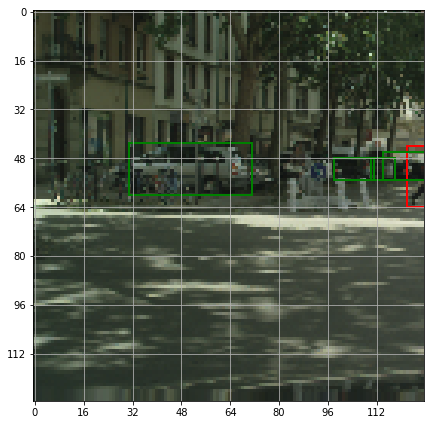

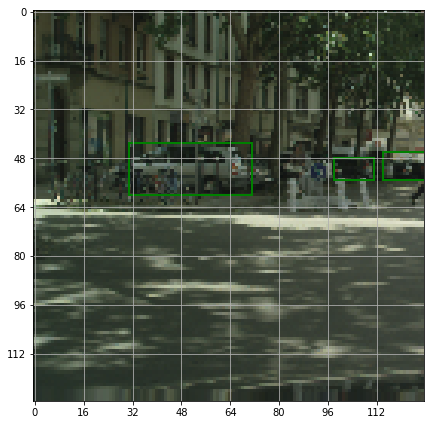

In [0]:
## test preproces
pre_process_test(19 , train_images, train_labels, my_labels)     

In [0]:
model = YOLOish().to(device)
epochs = 25
criterion = yolo_loss
optimizer = optim.Adam(model.parameters(), lr = 1e-03)

In [0]:
  

# Training loop called here
t_loss, mAP_loss, w_map, m1, m2, m3 = train(model, device,optimizer, criterion, 
                                         dataloader_train_hw2, dataloader_test_hw2, epochs)

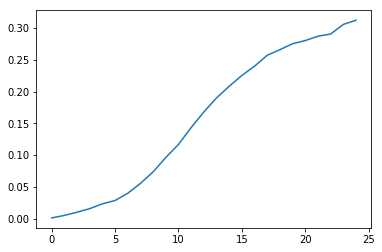

In [0]:
plt.plot(mAP_loss)

# Test your network

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.

In [0]:
my_im, wo_thres, post_thres, my_nms, true_label = nms(model, device, optimizer, dataloader_test_hw2)


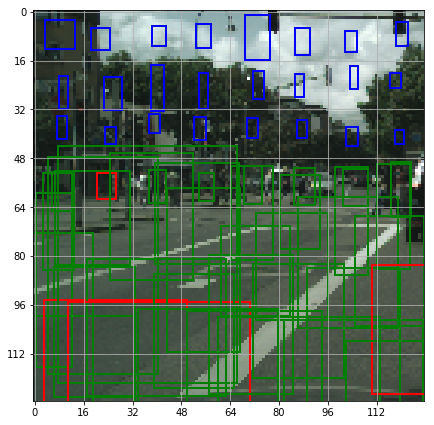

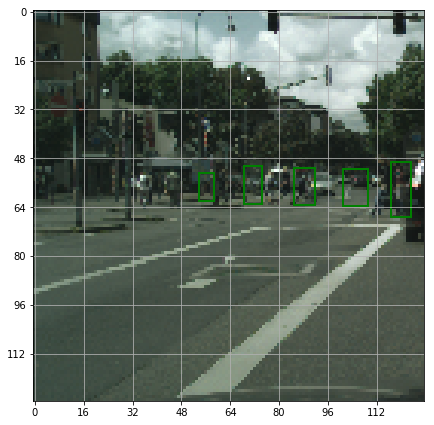

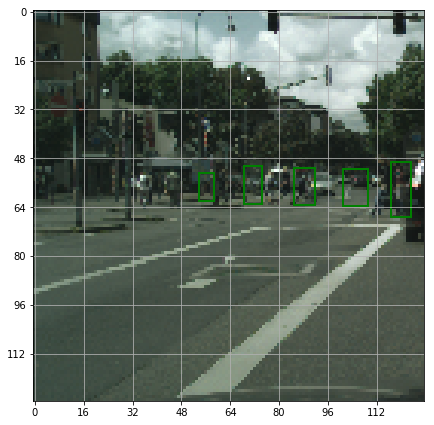

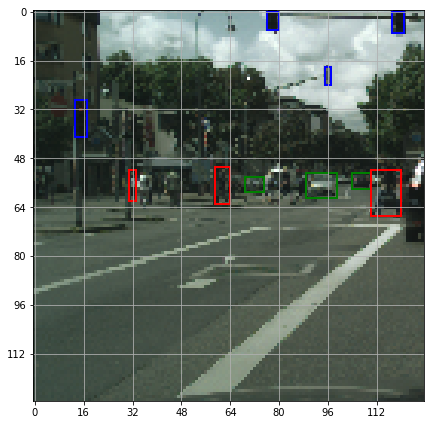

In [0]:
post_process_plot(my_im, wo_thres,post_thres, my_nms, true_label)

# **Mean Average Precision**

In [0]:
pre, rec, me1, me2, me3 = mean_P(model, device, optimizer, dataloader_test_hw2)

In [0]:
meanMAP, w_map = average_mAP(pre, rec)
